In [3]:
# Importing necessary libraries
import os
import numpy as np
import cv2
from pathlib import Path
import SimpleITK as sitk
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, shift, rotate, map_coordinates, gaussian_filter
from skimage.transform import resize
import zipfile
import gdown

from tensorflow.keras import layers, models, Input, regularizers, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import MeanIoU

# Ensure TensorFlow is using GPU if available
print(f"Using TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Using TensorFlow version: 2.16.1
Num GPUs Available: 0


In [4]:
main_path = Path.cwd()  # Get the current working directory

# Create the datasets folder if it doesn't exist
if not os.path.exists(main_path / 'datasets'):
    os.mkdir(main_path / 'datasets')

if not os.path.exists(main_path / 'datasets' / 'train') or not os.path.exists(main_path / 'datasets' / 'test'):
    
    # Download the dataset (zip)

    url = 'https://drive.google.com/file/d/1F9LFHyKA00G7aGNpF61D8GWeG54KiEam/view?usp=sharing'

    output = 'datasets/dataset.zip'

    gdown.download(url, output, quiet=False, fuzzy=True)

    # Unzip the dataset inside the datasets folder

    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(main_path / 'datasets')

    print('Dataset unzipped successfully!')
    
    # Remove the zip file
    os.remove(output)
else:
    print('Dataset already exists!')

Dataset already exists!


In [5]:
def load_mhd_image(image_path):
    """
    Loads a MetaImage (.mhd) file and returns it as a NumPy array.
    
    Args:
        image_path (Path): Path to the .mhd file.
    
    Returns:
        np.ndarray: 3D image array with shape (z, y, x).
    """
    try:
        image_sitk = sitk.ReadImage(str(image_path))
        image_np = sitk.GetArrayFromImage(image_sitk)  # Shape: (z, y, x)
        return image_np
    except Exception as e:
        print(f"[Loader] Error loading image {image_path.name}: {e}")
        return None

def load_mhd_mask(mask_path):
    """
    Loads a MetaImage (.mhd) file for the segmentation mask and returns it as a NumPy array.
    
    Args:
        mask_path (Path): Path to the mask .mhd file.
    
    Returns:
        np.ndarray: 3D mask array with shape (z, y, x), binary (0 and 1).
    """
    try:
        mask_sitk = sitk.ReadImage(str(mask_path))
        mask_np = sitk.GetArrayFromImage(mask_sitk)
        # Binarize the mask in case of any anomalies
        mask_np = (mask_np > 0).astype(np.float32)
        return mask_np
    except Exception as e:
        print(f"[Loader] Error loading mask {mask_path.name}: {e}")
        return None

In [6]:
def visualize_mri_and_mask(image, mask, slice_idx=None):
    """
    Visualizes a single slice of the MRI image and its corresponding mask.
    
    Args:
        image (np.ndarray): 3D MRI image array with shape (z, y, x).
        mask (np.ndarray): 3D mask array with shape (z, y, x).
        slice_idx (int, optional): Specific slice index to visualize. Defaults to the middle slice.
    """
    if slice_idx is None:
        slice_idx = image.shape[0] // 2  # Middle slice
    
    image_slice = image[slice_idx]
    mask_slice = mask[slice_idx]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_slice, cmap='gray')
    plt.title(f'MRI Slice {slice_idx}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_slice, cmap='gray')
    plt.title(f'Mask Slice {slice_idx}')
    plt.axis('off')
    
    plt.show()

In [7]:
def resample_image_and_mask(image_path, mask_path, new_spacing=(1.0, 1.0, 1.0)):
    """
    Resamples the image and mask to the desired voxel spacing.
    
    Args:
        image_path (Path): Path to the MRI .mhd file.
        mask_path (Path): Path to the mask .mhd file.
        new_spacing (tuple): Desired voxel spacing (z, y, x) in mm.
    
    Returns:
        tuple: Resampled image and mask as NumPy arrays.
    """
    try:
        # Read the image and mask using SimpleITK
        image_sitk = sitk.ReadImage(str(image_path))
        mask_sitk = sitk.ReadImage(str(mask_path))
        
        original_spacing = image_sitk.GetSpacing()
        original_size = image_sitk.GetSize()
        #print(f"[Resample] Original spacing: {original_spacing}, size: {original_size}")
    
        # Calculate the new size based on the new spacing
        new_size = [
            int(np.round(original_size[i] * (original_spacing[i] / new_spacing[i])))
            for i in range(3)
        ]
        #print(f"[Resample] New spacing: {new_spacing}, new size: {new_size}")
    
        # Resample image
        resample_image = sitk.Resample(
            image_sitk,
            new_size,
            sitk.Transform(),
            sitk.sitkLinear,
            image_sitk.GetOrigin(),
            new_spacing,
            image_sitk.GetDirection(),
            0,
            image_sitk.GetPixelID()
        )
    
        # Resample mask with nearest neighbor to preserve labels
        resample_mask = sitk.Resample(
            mask_sitk,
            new_size,
            sitk.Transform(),
            sitk.sitkNearestNeighbor,
            mask_sitk.GetOrigin(),
            new_spacing,
            mask_sitk.GetDirection(),
            0,
            mask_sitk.GetPixelID()
        )
    
        # Convert to NumPy arrays
        image_np = sitk.GetArrayFromImage(resample_image).astype(np.float32)
        mask_np = sitk.GetArrayFromImage(resample_mask).astype(np.float32)
        mask_np = (mask_np > 0).astype(np.float32)  # Ensure binary mask
    
        return image_np, mask_np
    except Exception as e:
        print(f"[Resample] Error resampling {image_path.name}: {e}")
        return None, None

In [8]:
def normalize_image(image):
    """
    Normalizes the image to have zero mean and unit variance.
    
    Args:
        image (np.ndarray): 3D image array.
    
    Returns:
        np.ndarray: Normalized image.
    """
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / (std + 1e-8)
    return normalized_image

In [9]:
def preprocess_case_2d(image_path, mask_path, new_spacing=(1.0, 1.0, 1.0)):
    """
    Preprocesses a single case for 2D processing: resampling, normalization, and mask binarization.

    Args:
        image_path (Path): Path to the MRI .mhd file.
        mask_path (Path): Path to the mask .mhd file.
        new_spacing (tuple): Desired voxel spacing (z, y, x) in mm.

    Returns:
        tuple: Preprocessed 3D image and mask as NumPy arrays.
    """
    # Resample the 3D image and mask
    image, mask = resample_image_and_mask(image_path, mask_path, new_spacing=new_spacing)
    if image is None or mask is None:
        return None, None

    # Normalize the image
    image = normalize_image(image)

    return image, mask

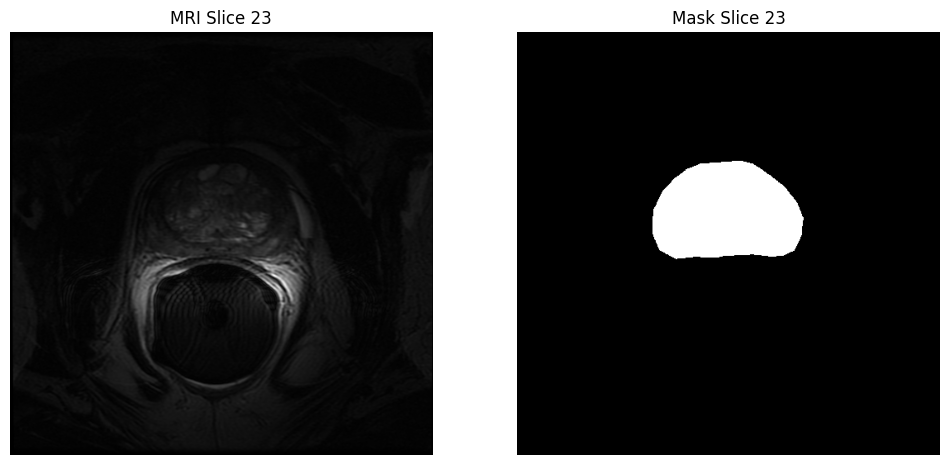

In [10]:
import re

# Define the path to your dataset
data_dir = Path("datasets/train")  # Update this path as needed

# Regex for non-segmentation files, there is no "_segmentation" in the filename
regex = re.compile(r"^(?!.*_segmentation).*\.mhd$", re.IGNORECASE)

# Select an example case, a CaseXX.mhd file and its corresponding CaseXX_segmentation.mhd file
example_case = None
example_mask = None

# Find the example case and mask
for case_file in data_dir.glob("*.mhd"):
    if regex.match(case_file.name):
        example_case = case_file
        example_mask = data_dir / f"{case_file.stem}_segmentation.mhd"
        break

# Load the image and mask
image = load_mhd_image(example_case)
mask = load_mhd_mask(example_mask)

# Visualize the loaded image and mask
visualize_mri_and_mask(image, mask)

In [11]:
def extract_slices(image, mask):
    """
    Extracts 2D slices from a 3D image and mask.

    Args:
        image (np.ndarray): 3D image array with shape (z, y, x).
        mask (np.ndarray): 3D mask array with shape (z, y, x).

    Yields:
        tuple: (image_slice, mask_slice) as NumPy arrays.
    """
    z, y, x = image.shape

    for slice_idx in range(z):
        image_slice = image[slice_idx, :, :]
        mask_slice = mask[slice_idx, :, :]

        yield image_slice, mask_slice
        

def calculate_steps_2d(data_dir, dataset_type, patch_depth, patch_size):
    """
    Calculates the total number of patches for a given dataset split.

    Args:
        data_dir (Path): Path to the dataset directory.
        dataset_type (str): 'train' or 'test'.
        patch_depth (int): Number of slices per patch.
        patch_size (tuple): Desired (height, width) of each patch.

    Returns:
        int: Total number of patches.
    """
    case_paths = sorted((data_dir / dataset_type).glob("Case*.mhd"))
    total_patches = 0
    for case_path in case_paths:
        mask_path = case_path.parent / (case_path.stem + "_segmentation.mhd")
        if not mask_path.exists():
            continue
        image, mask = preprocess_case_2d(case_path, mask_path)
        if image is None or mask is None:
            continue
        patches = list(extract_slices(image, mask))
        total_patches += len(patches)
    return total_patches

In [12]:
def random_brightness_contrast_2d(image, mask, brightness_range=(0.8, 1.2), contrast_range=(0.8, 1.2)):
    """
    Randomly adjusts brightness and contrast of a 2D image.
    
    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        brightness_range (tuple): Range for brightness adjustment.
        contrast_range (tuple): Range for contrast adjustment.
    
    Returns:
        tuple: Adjusted image and unchanged mask.
    """
    brightness = np.random.uniform(*brightness_range)
    contrast = np.random.uniform(*contrast_range)
    #print(f"[Augmentation] 2D Brightness: {brightness}, Contrast: {contrast}")
    
    image = image * brightness
    image = (image - np.mean(image)) * contrast + np.mean(image)
    image = np.clip(image, 0, 1)
    
    return image, mask

def random_affine_transform_2d(image, mask, rotation_range=(-10, 10), translation_range=(-5, 5), shear_range=(-5, 5), zoom_range=(0.9, 1.1)):
    """
    Applies random affine transformations to a 2D image and mask.
    
    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        rotation_range (tuple): Range of rotation angles in degrees.
        translation_range (tuple): Range for horizontal and vertical translations.
        shear_range (tuple): Shear angle range in degrees.
        zoom_range (tuple): Range for zoom.
    
    Returns:
        tuple: Transformed image and mask.
    """
    angle = np.random.uniform(*rotation_range)
    tx = np.random.uniform(*translation_range)
    ty = np.random.uniform(*translation_range)
    shear = np.random.uniform(*shear_range)
    zoom = np.random.uniform(*zoom_range)
    
    #print(f"[Augmentation] 2D Affine Transform - Angle: {angle}, Tx: {tx}, Ty: {ty}, Shear: {shear}, Zoom: {zoom}")
    
    # Build the affine transformation matrix
    affine_matrix = cv2.getRotationMatrix2D(center=(image.shape[1]/2, image.shape[0]/2), angle=angle, scale=zoom)
    affine_matrix[0, 2] += tx
    affine_matrix[1, 2] += ty
    
    # Apply affine transformation
    image_transformed = cv2.warpAffine(image, affine_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    mask_transformed = cv2.warpAffine(mask, affine_matrix, (mask.shape[1], mask.shape[0]), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    
    return image_transformed, mask_transformed


def random_zoom_2d(image, mask, zoom_range=(0.9, 1.1)):
    """
    Applies a random zoom to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        zoom_range (tuple): Tuple specifying the zoom range.

    Returns:
        tuple: Zoomed image and mask.
    """
    # Choose a random zoom factor
    zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
    #print(f"[Augmentation] 2D Zoom factor: {zoom_factor}")

    # Apply zoom to image
    image_zoomed = zoom(image, zoom=zoom_factor, order=1, mode='nearest')
    # Apply zoom to mask with nearest interpolation
    mask_zoomed = zoom(mask, zoom=zoom_factor, order=0, mode='nearest')

    # Crop or pad to original shape
    image_zoomed = crop_or_pad_2d(image_zoomed, image.shape)
    mask_zoomed = crop_or_pad_2d(mask_zoomed, mask.shape)

    return image_zoomed, mask_zoomed

def random_shift_2d(image, mask, shift_range=10):
    """
    Applies a random shift to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        shift_range (int): Maximum number of pixels to shift.

    Returns:
        tuple: Shifted image and mask.
    """
    # Generate random shifts for each axis
    shifts = np.random.uniform(-shift_range, shift_range, size=2)
    #print(f"[Augmentation] 2D Shifts: {shifts}")

    # Apply shift to image
    image_shifted = shift(image, shift=shifts, order=1, mode='nearest')
    # Apply shift to mask with nearest interpolation
    mask_shifted = shift(mask, shift=shifts, order=0, mode='nearest')

    return image_shifted, mask_shifted

def elastic_transform_2d(image, mask, alpha=1000, sigma=50):
    """
    Applies an elastic deformation to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        alpha (float): Scaling factor for intensity of deformation.
        sigma (float): Standard deviation for Gaussian filter.

    Returns:
        tuple: Elastically transformed image and mask.
    """
    random_state = np.random.RandomState(None)

    shape = image.shape
    #print(f"[Augmentation] 2D Elastic transform with alpha={alpha}, sigma={sigma}")

    # Generate random displacement fields
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # Create meshgrid
    y, x = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')

    # Apply displacements
    indices = (y + dy, x + dx)

    # Map coordinates
    image_transformed = map_coordinates(image, indices, order=1, mode='nearest')
    mask_transformed = map_coordinates(mask, indices, order=0, mode='nearest')

    return image_transformed, mask_transformed

def add_gaussian_noise_2d(image, mask, mean=0, std=0.01):
    """
    Adds Gaussian noise to a 2D image.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        mean (float): Mean of the Gaussian noise.
        std (float): Standard deviation of the Gaussian noise.

    Returns:
        tuple: Noisy image and unchanged mask.
    """
    #print(f"[Augmentation] Adding 2D Gaussian noise with mean={mean}, std={std}")
    noise = np.random.normal(mean, std, image.shape)
    image_noisy = image + noise
    image_noisy = np.clip(image_noisy, 0, 1)  # Ensure values are still in [0, 1]
    return image_noisy, mask

def random_rotation_2d(image, mask, angle_range=(-15, 15)):
    """
    Applies a random rotation to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        angle_range (tuple): Range of angles for rotation in degrees.

    Returns:
        tuple: Rotated image and mask.
    """
    angle = np.random.uniform(angle_range[0], angle_range[1])
    #print(f"[Augmentation] 2D Rotation angle: {angle} degrees")

    # Rotate image
    image_rotated = rotate(image, angle, reshape=False, order=1, mode='nearest')
    # Rotate mask with nearest interpolation
    mask_rotated = rotate(mask, angle, reshape=False, order=0, mode='nearest')

    return image_rotated, mask_rotated

def random_flip_2d(image, mask):
    """
    Applies random flipping along horizontal and vertical axes to a 2D image and mask.

    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.

    Returns:
        tuple: Flipped or unchanged image and mask.
    """
    # Horizontal flip
    if np.random.rand() > 0.5:
        #print(f"[Augmentation] 2D Horizontal flipping")
        image = np.fliplr(image)
        mask = np.fliplr(mask)

    # Vertical flip
    if np.random.rand() > 0.5:
        #print(f"[Augmentation] 2D Vertical flipping")
        image = np.flipud(image)
        mask = np.flipud(mask)

    return image, mask

def crop_or_pad_2d(image, target_shape):
    """
    Crops or pads a 2D image to match the target shape.

    Args:
        image (np.ndarray): 2D image to be resized.
        target_shape (tuple): Desired shape (height, width).

    Returns:
        np.ndarray: Resized image.
    """
    current_shape = image.shape
    padding = []
    cropping = []
    for i in range(2):  # y, x
        if current_shape[i] < target_shape[i]:
            total_pad = target_shape[i] - current_shape[i]
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            padding.append((pad_before, pad_after))
            cropping.append((0, current_shape[i]))
        elif current_shape[i] > target_shape[i]:
            total_crop = current_shape[i] - target_shape[i]
            crop_before = total_crop // 2
            crop_after = crop_before + target_shape[i]
            cropping.append((crop_before, crop_after))
            padding.append((0, 0))
        else:
            cropping.append((0, current_shape[i]))
            padding.append((0, 0))

    # Crop
    y_min, y_max = cropping[0]
    x_min, x_max = cropping[1]
    image_cropped = image[y_min:y_max, x_min:x_max]

    # Pad
    y_pad, x_pad = padding
    image_padded = np.pad(
        image_cropped,
        ((y_pad[0], y_pad[1]),
         (x_pad[0], x_pad[1])),
        mode='constant',
        constant_values=0
    )

    return image_padded


def augment_data_2d(image, mask, augmentations):
    """
    Applies a series of augmentations to a 2D image and mask.
    
    Args:
        image (np.ndarray): 2D image array.
        mask (np.ndarray): 2D mask array.
        augmentations (dict): Dictionary specifying which augmentations to apply and their parameters.
    
    Returns:
        tuple: Augmented image and mask.
    """
    # Random Zoom
    if augmentations.get('zoom', False):
        image, mask = random_zoom_2d(image, mask, zoom_range=augmentations.get('zoom_range', (0.9, 1.1)))

    # Random Shift
    if augmentations.get('shift', False):
        image, mask = random_shift_2d(image, mask, shift_range=augmentations.get('shift_range', 10))

    # Elastic Transformation
    if augmentations.get('elastic', False):
        image, mask = elastic_transform_2d(image, mask,
                                           alpha=augmentations.get('elastic_alpha', 1000),
                                           sigma=augmentations.get('elastic_sigma', 50))

    # Adding Gaussian Noise
    if augmentations.get('noise', False):
        image, mask = add_gaussian_noise_2d(image, mask,
                                           mean=augmentations.get('noise_mean', 0),
                                           std=augmentations.get('noise_std', 0.01))

    # Random Rotation
    if augmentations.get('rotation', False):
        image, mask = random_rotation_2d(image, mask, angle_range=augmentations.get('rotation_range', (-15, 15)))

    # Random Flipping
    if augmentations.get('flip', False):
        image, mask = random_flip_2d(image, mask)

    # Random Brightness and Contrast
    if augmentations.get('brightness_contrast', False):
        image, mask = random_brightness_contrast_2d(image, mask,
                                                   brightness_range=augmentations.get('brightness_range', (0.8, 1.2)),
                                                   contrast_range=augmentations.get('contrast_range', (0.8, 1.2)))

    # Random Affine Transformation
    #if augmentations.get('affine', False):
    #    image, mask = random_affine_transform_2d(image, mask,
    #                                             rotation_range=augmentations.get('affine_rotation_range', (-10, 10)),
    #                                             translation_range=augmentations.get('affine_translation_range', (-5, 5)),
    #                                             shear_range=augmentations.get('affine_shear_range', (-5, 5)),
    #                                             zoom_range=augmentations.get('affine_zoom_range', (0.9, 1.1)))

    return image, mask

In [13]:
def dataset_generator_2d(data_dir, batch_size, patch_size=(128, 128), dataset_type='train', augmentations=None):
    """
    A generator to load, preprocess, augment, and output the dataset in batches for 2D processing.

    Args:
        data_dir (Path): Path to the dataset folder with `train` and `test` subfolders.
        batch_size (int): The number of samples per batch.
        patch_size (tuple): Desired (height, width) of each patch.
        dataset_type (str): 'train' or 'test' to determine the dataset split.
        augmentations (dict): Dictionary specifying augmentations to apply.

    Yields:
        tuple: (images, masks) batches.
    """
    # Find all .mhd files for the dataset without segmentation files
    case_paths = sorted((data_dir / dataset_type).glob("Case*.mhd"))
    
    # remove cases
    #print(f"[Generator_2D] Found {len(case_paths)} cases in '{dataset_type}' set.")
    
    while True:  # Infinite loop for generator
        # Shuffle the cases at the beginning of each epoch
        if dataset_type == 'train':
            shuffled_indices = np.random.permutation(len(case_paths))
            #print("[Generator_2D] Shuffling data for new epoch.")
        else:
            shuffled_indices = np.arange(len(case_paths))  # No shuffling for validation
    
        image_batch = []
        mask_batch = []
    
        for idx in shuffled_indices:
            case_path = case_paths[idx]
            #print(f"[Generator_2D] Processing {case_path.name}...")
    
            # Construct segmentation path (assuming naming convention)
            
            # If there are no segmentation in the filename
            if("segmentation" not in case_path.stem):
                segmentation_path = case_path.parent / (case_path.stem + "_segmentation.mhd")
            else:
                continue
            #print('\n\n\n\n\n'+segmentation_path+'\n\n\n\n\n')

            #print(f"\n\n\n\n\n\n[Generator_2D] Processing {segmentation_path}...\n\n\n\n\n\n")
            
            # Check if the segmentation file exists
            if not segmentation_path.exists():
                print(f"[Generator_2D] Segmentation file not found for {case_path.name}. Skipping.")
                continue
    
            # Preprocess the image and mask
            image, mask = preprocess_case_2d(case_path, segmentation_path)
            if image is None or mask is None:
                print(f"[Generator_2D] Failed to preprocess data for {case_path.name}. Skipping.")
                continue
    
            # Extract 2D slices from the image and mask
            slice_generator = extract_slices(image, mask)
            num_slices = 0
    
            for image_slice, mask_slice in slice_generator:
                # Apply augmentations if specified and if in training set
                if augmentations and dataset_type == 'train':
                    image_slice, mask_slice = augment_data_2d(image_slice, mask_slice, augmentations)
    
                # Crop or pad the slices to the desired patch size
                image_slice = crop_or_pad_2d(image_slice, patch_size)
                mask_slice = crop_or_pad_2d(mask_slice, patch_size)
    
                # Normalize image
                image_slice = image_slice.astype(np.float32)
                # Already normalized in preprocess_case_2d
    
                # Binarize mask (already done in preprocess_case_2d)
    
                # Add channel dimension
                image_slice = np.expand_dims(image_slice, axis=-1)  # Shape: (height, width, 1)
                mask_slice = np.expand_dims(mask_slice, axis=-1)    # Shape: (height, width, 1)
    
                image_batch.append(image_slice)
                mask_batch.append(mask_slice)
                num_slices += 1
    
                if len(image_batch) == batch_size:
                    #print(f"[Generator_2D] Yielding a batch of {batch_size} samples.")
                    yield np.array(image_batch), np.array(mask_batch)
                    image_batch = []
                    mask_batch = []
    
            #print(f"[Generator_2D] Extracted {num_slices} slices from {case_path.name}.")
    
        # Yield any remaining slices that didn't make a full batch
        if len(image_batch) > 0:
            #print(f"[Generator_2D] Yielding the final batch of {len(image_batch)} samples.")
            yield np.array(image_batch), np.array(mask_batch)
            image_batch = []
            mask_batch = []

In [14]:
def residual_block_2d_spatial_dropout(input_tensor, filters, dropout_rate=0.2, l2_reg=1e-5):
    """
    Create a residual block for the 2D segmentation model with Spatial Dropout.
    
    Args:
        input_tensor (tf.Tensor): Input tensor.
        filters (int): Number of filters for the convolutional layers.
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.
    
    Returns:
        tf.Tensor: Output tensor after applying the residual block.
    """
    reg = regularizers.l2(l2_reg)

    # First convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    # Projection shortcut if input and output shapes differ
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, kernel_size=(1, 1), padding="same", kernel_regularizer=reg)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    # Add skip connection
    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)

    # Add Spatial Dropout
    x = layers.SpatialDropout2D(dropout_rate)(x)
    return x


def build_residual_2d_unet_spatial_dropout(input_shape=(128, 128, 1), dropout_rate=0.2, l2_reg=1e-5):
    """
    Build a residual-based 2D U-Net segmentation model with Spatial Dropout.
    
    Args:
        input_shape (tuple): Shape of the input data (height, width, channels).
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.
    
    Returns:
        tf.keras.Model: Compiled 2D U-Net model with Spatial Dropout.
    """
    inputs = Input(shape=input_shape)
    print(f"[Model_2D_SpatialDropout] Input shape: {inputs.shape}")

    # Encoder
    c1 = layers.Conv2D(16, kernel_size=(3, 3), padding="same", kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    c1 = residual_block_2d_spatial_dropout(c1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)   # (64x64x16)

    c2 = residual_block_2d_spatial_dropout(p1, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)   # (32x32x32)

    c3 = residual_block_2d_spatial_dropout(p2, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)   # (16x16x64)

    # Bottleneck
    c4 = residual_block_2d_spatial_dropout(p3, filters=128, dropout_rate=dropout_rate, l2_reg=l2_reg)
    print(f"[Model_2D_SpatialDropout] Bottleneck shape: {c4.shape}")

    # Decoder
    u3 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(c4)
    u3 = layers.concatenate([u3, c3])
    c5 = residual_block_2d_spatial_dropout(u3, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg) # (32x32x64)

    u2 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = residual_block_2d_spatial_dropout(u2, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg) # (64x64x32)

    u1 = layers.Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding="same")(c6)
    u1 = layers.concatenate([u1, c1])
    c7 = residual_block_2d_spatial_dropout(u1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg) # (128x128x16)

    # Output layer
    outputs = layers.Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(c7)
    print(f"[Model_2D_SpatialDropout] Output shape: {outputs.shape}")

    model = models.Model(inputs, outputs)
    return model

In [15]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Input

def attention_gate(x, gating, inter_shape):
    """
    Creates an attention gate to focus on relevant features.
    
    Args:
        x (tf.Tensor): Input tensor from the encoder.
        gating (tf.Tensor): Tensor from the decoder (gating signal).
        inter_shape (int): Number of intermediate filters.
    
    Returns:
        tf.Tensor: Output tensor after applying attention.
    """
    # Theta path (downsampled)
    theta_x = layers.Conv2D(inter_shape, kernel_size=(1,1), strides=(2,2), padding='same')(x)  # Shape: (16,16,32)
    
    # Phi path (no downsampling)
    phi_g = layers.Conv2D(inter_shape, kernel_size=(1,1), padding='same')(gating)  # Shape: (32,32,32)
    phi_g = layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same')(phi_g)  # Shape: (16,16,32)
    
    # Add theta_x and phi_g
    add_xg = layers.add([theta_x, phi_g])  # Shape: (16,16,32)
    act_xg = layers.Activation('relu')(add_xg)
    
    # Psi path
    psi = layers.Conv2D(1, kernel_size=(1,1), padding='same')(act_xg)  # Shape: (16,16,1)
    psi = layers.Activation('sigmoid')(psi)  # Shape: (16,16,1)
    
    # Upsample psi to match the encoder feature map size
    upsample_psi = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(psi)  # Shape: (32,32,1)
    
    # Multiply attention coefficients with the original encoder feature map
    attn_coefficients = layers.multiply([x, upsample_psi])  # Shape: (32,32,64) * (32,32,1) = (32,32,64)
    
    return attn_coefficients


def residual_block_2d_attention(input_tensor, filters, dropout_rate=0.2, l2_reg=1e-5):
    """
    Create a residual block for the 2D segmentation model with Spatial Dropout and Attention.
    
    Args:
        input_tensor (tf.Tensor): Input tensor.
        filters (int): Number of filters for the convolutional layers.
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.
    
    Returns:
        tf.Tensor: Output tensor after applying the residual block.
    """
    reg = regularizers.l2(l2_reg)

    # First convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    # Projection shortcut if input and output shapes differ
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, kernel_size=(1, 1), padding="same", kernel_regularizer=reg)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    # Add skip connection
    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)

    # Add Spatial Dropout
    x = layers.SpatialDropout2D(dropout_rate)(x)
    return x

def build_residual_2d_unet_attention(input_shape=(128, 128, 1), dropout_rate=0.2, l2_reg=1e-5):
    """
    Build a residual-based 2D U-Net segmentation model with Attention Mechanism.
    
    Args:
        input_shape (tuple): Shape of the input data (height, width, channels).
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.
    
    Returns:
        tf.keras.Model: Compiled 2D U-Net model with Attention Mechanism.
    """
    inputs = Input(shape=input_shape)
    print(f"[Model_2D_Attention] Input shape: {inputs.shape}")

    # Encoder
    c1 = layers.Conv2D(16, kernel_size=(3, 3), padding="same", kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    c1 = residual_block_2d_attention(c1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)   # (64x64x16)

    c2 = residual_block_2d_attention(p1, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)   # (32x32x32)

    c3 = residual_block_2d_attention(p2, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)   # (16x16x64)

    # Bottleneck
    c4 = residual_block_2d_attention(p3, filters=128, dropout_rate=dropout_rate, l2_reg=l2_reg)
    print(f"[Model_2D_Attention] Bottleneck shape: {c4.shape}")

    # Decoder
    u3 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(c4)
    # Apply attention gate
    attn3 = attention_gate(c3, u3, inter_shape=32)
    u3 = layers.multiply([u3, attn3])  # Apply attention coefficients
    c5 = residual_block_2d_attention(u3, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg) # (32x32x64)

    u2 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(c5)
    attn2 = attention_gate(c2, u2, inter_shape=16)
    u2 = layers.multiply([u2, attn2])  # Apply attention coefficients
    c6 = residual_block_2d_attention(u2, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg) # (64x64x32)

    u1 = layers.Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding="same")(c6)
    attn1 = attention_gate(c1, u1, inter_shape=8)
    u1 = layers.multiply([u1, attn1])  # Apply attention coefficients
    c7 = residual_block_2d_attention(u1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg) # (128x128x16)

    # Output layer
    outputs = layers.Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(c7)
    print(f"[Model_2D_Attention] Output shape: {outputs.shape}")

    model = models.Model(inputs, outputs)
    return model

In [16]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Input

def squeeze_excite_block(input_tensor, ratio=16):
    """
    Create a Squeeze-and-Excitation (SE) block.
    
    Args:
        input_tensor (tf.Tensor): Input tensor.
        ratio (int): Reduction ratio for the SE block.
    
    Returns:
        tf.Tensor: Output tensor after applying SE block.
    """
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    
    se = layers.GlobalAveragePooling2D()(init)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Reshape((1, 1, filters))(se)
    x = layers.multiply([init, se])
    return x

def residual_block_2d_se(input_tensor, filters, dropout_rate=0.2, l2_reg=1e-5, ratio=16):
    """
    Create a residual block for the 2D segmentation model with SE Blocks and Spatial Dropout.
    
    Args:
        input_tensor (tf.Tensor): Input tensor.
        filters (int): Number of filters for the convolutional layers.
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.
        ratio (int): Reduction ratio for the SE block.
    
    Returns:
        tf.Tensor: Output tensor after applying the residual block.
    """
    reg = regularizers.l2(l2_reg)

    # First convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same", kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    # Squeeze-and-Excitation
    x = squeeze_excite_block(x, ratio=ratio)

    # Projection shortcut if input and output shapes differ
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, kernel_size=(1, 1), padding="same", kernel_regularizer=reg)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    # Add skip connection
    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)

    # Add Spatial Dropout
    x = layers.SpatialDropout2D(dropout_rate)(x)
    return x


def build_residual_2d_unet_se(input_shape=(128, 128, 1), dropout_rate=0.2, l2_reg=1e-5, se_ratio=16):
    """
    Build a residual-based 2D U-Net segmentation model with Squeeze-and-Excitation (SE) Blocks.
    
    Args:
        input_shape (tuple): Shape of the input data (height, width, channels).
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization factor.
        se_ratio (int): Reduction ratio for the SE blocks.
    
    Returns:
        tf.keras.Model: Compiled 2D U-Net model with SE Blocks.
    """
    inputs = Input(shape=input_shape)
    print(f"[Model_2D_SE] Input shape: {inputs.shape}")

    # Encoder
    c1 = layers.Conv2D(16, kernel_size=(3, 3), padding="same", kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    c1 = residual_block_2d_se(c1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg, ratio=se_ratio)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)   # (64x64x16)

    c2 = residual_block_2d_se(p1, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg, ratio=se_ratio)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)   # (32x32x32)

    c3 = residual_block_2d_se(p2, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg, ratio=se_ratio)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)   # (16x16x64)

    # Bottleneck
    c4 = residual_block_2d_se(p3, filters=128, dropout_rate=dropout_rate, l2_reg=l2_reg, ratio=se_ratio)
    print(f"[Model_2D_SE] Bottleneck shape: {c4.shape}")

    # Decoder
    u3 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(c4)
    u3 = layers.concatenate([u3, c3])
    c5 = residual_block_2d_se(u3, filters=64, dropout_rate=dropout_rate, l2_reg=l2_reg, ratio=se_ratio) # (32x32x64)

    u2 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = residual_block_2d_se(u2, filters=32, dropout_rate=dropout_rate, l2_reg=l2_reg, ratio=se_ratio) # (64x64x32)

    u1 = layers.Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding="same")(c6)
    u1 = layers.concatenate([u1, c1])
    c7 = residual_block_2d_se(u1, filters=16, dropout_rate=dropout_rate, l2_reg=l2_reg, ratio=se_ratio) # (128x128x16)

    # Output layer
    outputs = layers.Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(c7)
    print(f"[Model_2D_SE] Output shape: {outputs.shape}")

    model = models.Model(inputs, outputs)
    return model

In [17]:
def count_cases(data_dir, dataset_type):
    """
    Count the number of cases in the dataset.

    Args:
        data_dir (Path): Path to the dataset directory.
        dataset_type (str): 'train' or 'test'.

    Returns:
        int: Number of cases.
    """
    num_cases = len(list((data_dir / dataset_type).glob("Case*.mhd")))
    #print(f"[Info] Number of {dataset_type} cases: {num_cases}")
    return num_cases

In [18]:
import datetime
from pathlib import Path

# Define paths and parameters
data_dir = Path("datasets")  # Update this path as needed
batch_size = 2
patch_size = (128, 128)
input_shape = (patch_size[0], patch_size[1], 1)
epochs = 50
patience = 5

# Define augmentation parameters
augmentations = {
    'zoom': True,
    'zoom_range': (0.9, 1.1),
    'shift': True,
    'shift_range': 10,
    'elastic': True,
    'elastic_alpha': 1000,
    'elastic_sigma': 50,
    'noise': True,
    'noise_mean': 0,
    'noise_std': 0.01,
    'rotation': True,
    'rotation_range': (-15, 15),
    'flip': True,
    'brightness_contrast': True,
    'brightness_range': (0.8, 1.2),
    'contrast_range': (0.8, 1.2),
    'affine': True,
    'affine_rotation_range': (-10, 10),
    'affine_translation_range': (-5, 5),
    'affine_shear_range': (-5, 5),
    'affine_zoom_range': (0.9, 1.1)
}

In [19]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Computes the Dice Coefficient.

    Args:
        y_true (tf.Tensor): Ground truth masks.
        y_pred (tf.Tensor): Predicted masks.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        tf.Tensor: Dice coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """
    Computes the Dice Loss.

    Args:
        y_true (tf.Tensor): Ground truth masks.
        y_pred (tf.Tensor): Predicted masks.

    Returns:
        tf.Tensor: Dice loss.
    """
    return 1 - dice_coefficient(y_true, y_pred)

In [20]:
def train_model(model_builder, model_name, data_dir, batch_size, patch_size, input_shape, epochs, patience, augmentations, l2_reg=1e-5):
    """
    Trains and saves a model based on the provided model builder function.
    
    Args:
        model_builder (function): Function to build the model.
        model_name (str): Name identifier for the model.
        data_dir (Path): Path to the dataset directory.
        batch_size (int): Batch size for training.
        patch_size (tuple): Desired (height, width) of each patch.
        input_shape (tuple): Shape of the input data (height, width, channels).
        epochs (int): Number of training epochs.
        patience (int): Patience for EarlyStopping.
        augmentations (dict): Dictionary specifying augmentations to apply.
        l2_reg (float): L2 regularization factor.
    
    Returns:
        tf.keras.Model: Trained model.
    """
    # Initialize generators
    train_generator = dataset_generator_2d(
        data_dir=data_dir,
        batch_size=batch_size,
        patch_size=patch_size,
        dataset_type="train",
        augmentations=augmentations
    )
    val_generator = dataset_generator_2d(
        data_dir=data_dir,
        batch_size=batch_size,
        patch_size=patch_size,
        dataset_type="test",
        augmentations=None
    )
    
    # Calculate steps
    num_train_slices = calculate_steps_2d(data_dir, 'train', 8, patch_size)
    num_val_slices = calculate_steps_2d(data_dir, 'test', 8, patch_size)
    
    steps_per_epoch = num_train_slices // batch_size
    validation_steps = num_val_slices // batch_size
    
    print(f"[Train {model_name}] Total training slices: {num_train_slices}, Steps per epoch: {steps_per_epoch}")
    print(f"[Train {model_name}] Total validation slices: {num_val_slices}, Validation steps: {validation_steps}")
    
    # Build the model
    model = model_builder(input_shape=input_shape, dropout_rate=0.3, l2_reg=l2_reg)
    model.summary()
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=dice_loss,
        metrics=[dice_coefficient, 'accuracy', MeanIoU(num_classes=2)]
    )
    print(f"[Train {model_name}] Model compiled successfully.")
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        f"best_model_{model_name}.keras",
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    early_stop = EarlyStopping(
        monitor='val_dice_coefficient',
        patience=patience,
        mode='max',
        verbose=1,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        mode='min',
        min_lr=1e-6
    )
    tensorboard_callback = TensorBoard(
        log_dir=f"logs/{model_name}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
        histogram_freq=1
    )
    
    callbacks = [checkpoint, early_stop, reduce_lr, tensorboard_callback]
    
    # Train the model
    print(f"[Train {model_name}] Starting training...")
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks
    )
    print(f"[Train {model_name}] Training completed.")
    
    # Save the final model
    model.save(f"final_model_{model_name}.keras")
    print(f"[Train {model_name}] Final model saved as 'final_model_{model_name}.keras'.")
    
    return model

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

train = input("Train the models? (y/n): ")

if train.lower() != 'y':
    print("Exiting...")

else:
    # Estimate number of steps per epoch
    # For precise calculation, determine the total number of patches per epoch
    # Here, we'll set steps_per_epoch and validation_steps to fixed numbers
    steps_per_epoch = 100
    validation_steps = 20
    
    # Train Model 1: Residual U-Net with Spatial Dropout
    model1 = train_model(
        model_builder=build_residual_2d_unet_spatial_dropout,
        model_name="residual_spatial_dropout",
        data_dir=data_dir,
        batch_size=batch_size,
        patch_size=patch_size,
        input_shape=input_shape,
        epochs=epochs,
        patience=patience,
        augmentations=augmentations,
        l2_reg=1e-5
    )
    
    # Train Model 2: Residual U-Net with Attention Mechanism
    model2 = train_model(
        model_builder=build_residual_2d_unet_attention,
        model_name="residual_attention",
        data_dir=data_dir,
        batch_size=batch_size,
        patch_size=patch_size,
        input_shape=input_shape,
        epochs=epochs,
        patience=patience,
        augmentations=augmentations,
        l2_reg=1e-5
    )
    
    # Train Model 3: Residual U-Net with SE Blocks
    model3 = train_model(
        model_builder=build_residual_2d_unet_se,
        model_name="residual_se",
        data_dir=data_dir,
        batch_size=batch_size,
        patch_size=patch_size,
        input_shape=input_shape,
        epochs=epochs,
        patience=patience,
        augmentations=augmentations,
        l2_reg=1e-5
    )

In [21]:
from tensorflow.keras.models import load_model

# Paths to the best models
model_paths = [
    "best_model_residual_spatial_dropout.keras",
    "best_model_residual_attention.keras",
    "best_model_residual_se.keras"
]

# Load the models
ensemble_models = []
for idx, path in enumerate(model_paths, 1):
    try:
        model = load_model(
            path,
            custom_objects={
                'dice_loss': dice_loss,
                'dice_coefficient': dice_coefficient
            }
        )
        ensemble_models.append(model)
        print(f"[Ensemble] Loaded Model {idx} from '{path}'.")
    except Exception as e:
        print(f"[Ensemble] Error loading Model {idx} from '{path}': {e}")

[Ensemble] Loaded Model 1 from 'best_model_residual_spatial_dropout.keras'.
[Ensemble] Loaded Model 2 from 'best_model_residual_attention.keras'.
[Ensemble] Loaded Model 3 from 'best_model_residual_se.keras'.


In [22]:
import numpy as np

def visualize_batch_2d(images, masks, predictions=None, num_samples=2):
    """
    Visualizes samples from a batch of 2D images and masks, and optionally predictions.

    Args:
        images (np.ndarray): Batch of images with shape (batch_size, height, width, 1).
        masks (np.ndarray): Batch of masks with shape (batch_size, height, width, 1).
        predictions (np.ndarray, optional): Batch of predicted masks with the same shape as masks.
        num_samples (int): Number of samples to visualize from the batch.
    """
    batch_size = images.shape[0]
    num_samples = min(num_samples, batch_size)
    
    for i in range(num_samples):
        image = images[i, :, :, 0]  # Shape: (height, width)
        mask = masks[i, :, :, 0]    # Shape: (height, width)
        if predictions is not None:
            pred = predictions[i, :, :, 0]  # Shape: (height, width)

        # Select the center slice (for 2D, this is the only slice)
        # Alternatively, implement logic to select specific slices if needed

        # Create a figure with subplots
        if predictions is not None:
            num_plots = 4  # MRI, Ground Truth, Prediction, Overlay, Difference
        else:
            num_plots = 2  # MRI and Ground Truth

        plt.figure(figsize=(24, 6))

        # MRI Image
        plt.subplot(1, num_plots, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Sample {i+1} - MRI Image')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, num_plots, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Sample {i+1} - Ground Truth')
        plt.axis('off')

        if predictions is not None:
            # Predicted Mask
            plt.subplot(1, num_plots, 3)
            plt.imshow(pred, cmap='gray')
            plt.title(f'Sample {i+1} - Prediction')
            plt.axis('off')

            # Overlay of Prediction on MRI
            plt.subplot(1, num_plots, 4)
            plt.imshow(image, cmap='gray')
            plt.imshow(pred, cmap='jet', alpha=0.5)
            plt.title(f'Sample {i+1} - Prediction Overlay')
            plt.axis('off')

            # Optionally, add a difference map
            # Uncomment the following lines if you want to include it
            # difference = np.abs(mask - pred)
            # plt.figure(figsize=(6, 6))
            # plt.imshow(image, cmap='gray')
            # plt.imshow(difference, cmap='Reds', alpha=0.5)
            # plt.title(f'Sample {i+1} - Prediction Difference')
            # plt.axis('off')
            # plt.show()

        plt.tight_layout()
        plt.show()


def ensemble_predict(models, images):
    """
    Generates ensemble predictions by averaging the outputs of multiple models.
    
    Args:
        models (list): List of trained tf.keras.Model instances.
        images (np.ndarray): Batch of images to predict with shape (batch_size, height, width, channels).
    
    Returns:
        np.ndarray: Averaged predictions with shape (batch_size, height, width, 1).
    """
    # Collect predictions from each model
    predictions = [model.predict(images) for model in models]
    print(f"[Ensemble] Collected predictions from {len(models)} models.")
    
    # Compute the average of predictions
    avg_prediction = np.mean(predictions, axis=0)
    print(f"[Ensemble] Averaged predictions shape: {avg_prediction.shape}")
    
    return avg_prediction

def evaluate_ensemble(models, val_generator, validation_steps):
    """
    Evaluates the ensemble of models on the validation set.
    
    Args:
        models (list): List of trained tf.keras.Model instances.
        val_generator (generator): Validation data generator.
        validation_steps (int): Number of validation steps.
    
    Returns:
        dict: Aggregated evaluation metrics.
    """
    all_metrics = {
        'dice_coefficient': [],
        'accuracy': [],
        'mean_iou': []
    }
    
    print("[Ensemble Evaluation] Starting evaluation on validation set...")
    
    for step in range(validation_steps):
        print(f"\n[Ensemble Evaluation] Processing step {step + 1}/{validation_steps}...")
        images, masks = next(val_generator)
        print(f"[Ensemble Evaluation] Batch shapes - Images: {images.shape}, Masks: {masks.shape}")
        
        # Generate ensemble predictions
        preds = ensemble_predict(models, images)
        preds_binary = (preds > 0.5).astype(np.float32)
        print(f"[Ensemble Evaluation] Predictions thresholded to binary masks.")
        
        # Calculate metrics
        dice = dice_coefficient(masks, preds_binary).numpy()
        acc = tf.keras.metrics.binary_accuracy(masks, preds_binary).numpy().mean()
        miou_metric = MeanIoU(num_classes=2)
        miou_metric.update_state(masks, preds_binary)
        miou = miou_metric.result().numpy()
        
        # Append metrics
        all_metrics['dice_coefficient'].append(dice)
        all_metrics['accuracy'].append(acc)
        all_metrics['mean_iou'].append(miou)
        
        print(f"[Ensemble Evaluation] Dice Coefficient: {dice:.4f}, Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")
    
    # Calculate average metrics
    avg_metrics = {metric: np.mean(values) for metric, values in all_metrics.items()}
    print("\n[Ensemble Evaluation] Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"[Ensemble Evaluation] {metric}: {value:.4f}")
    
    return avg_metrics

def visualize_ensemble_predictions(models, val_generator, num_batches=2, num_samples=2):
    """
    Visualizes ensemble predictions on the validation set.
    
    Args:
        models (list): List of trained tf.keras.Model instances.
        val_generator (generator): Validation data generator.
        num_batches (int): Number of batches to visualize.
        num_samples (int): Number of samples per batch to visualize.
    """
    print("[Ensemble Visualization] Starting visualization of ensemble predictions...")
    
    for batch_num in range(num_batches):
        print(f"\n[Ensemble Visualization] Processing batch {batch_num + 1}/{num_batches}...")
        images, masks = next(val_generator)
        print(f"[Ensemble Visualization] Batch shapes - Images: {images.shape}, Masks: {masks.shape}")
        
        # Generate ensemble predictions
        preds = ensemble_predict(models, images)
        preds_binary = (preds > 0.5).astype(np.float32)
        print("[Ensemble Visualization] Predictions thresholded to binary masks.")
        
        # Visualize
        visualize_batch_2d(images, masks, predictions=preds_binary, num_samples=num_samples)

[Ensemble Evaluation] Starting evaluation on validation set...

[Ensemble Evaluation] Processing step 1/10...
[Ensemble Evaluation] Batch shapes - Images: (2, 128, 128, 1), Masks: (2, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[Ensemble] Collected predictions from 3 models.
[Ensemble] Averaged predictions shape: (2, 128, 128, 1)
[Ensemble Evaluation] Predictions thresholded to binary masks.
[Ensemble Evaluation] Dice Coefficient: 0.0000, Accuracy: 0.9723, Mean IoU: 0.4861

[Ensemble Evaluation] Processing step 2/10...
[Ensemble Evaluation] Batch shapes - Images: (2, 128, 128, 1), Masks: (2, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[Ensemble] Collected predictions from 3 models.
[Ensemble] Averaged predictions shape: (2, 128, 128, 1)
[Ensemble Evaluation] Predictions thresholded to binary masks.
[Ensemble Evaluation] Dice 

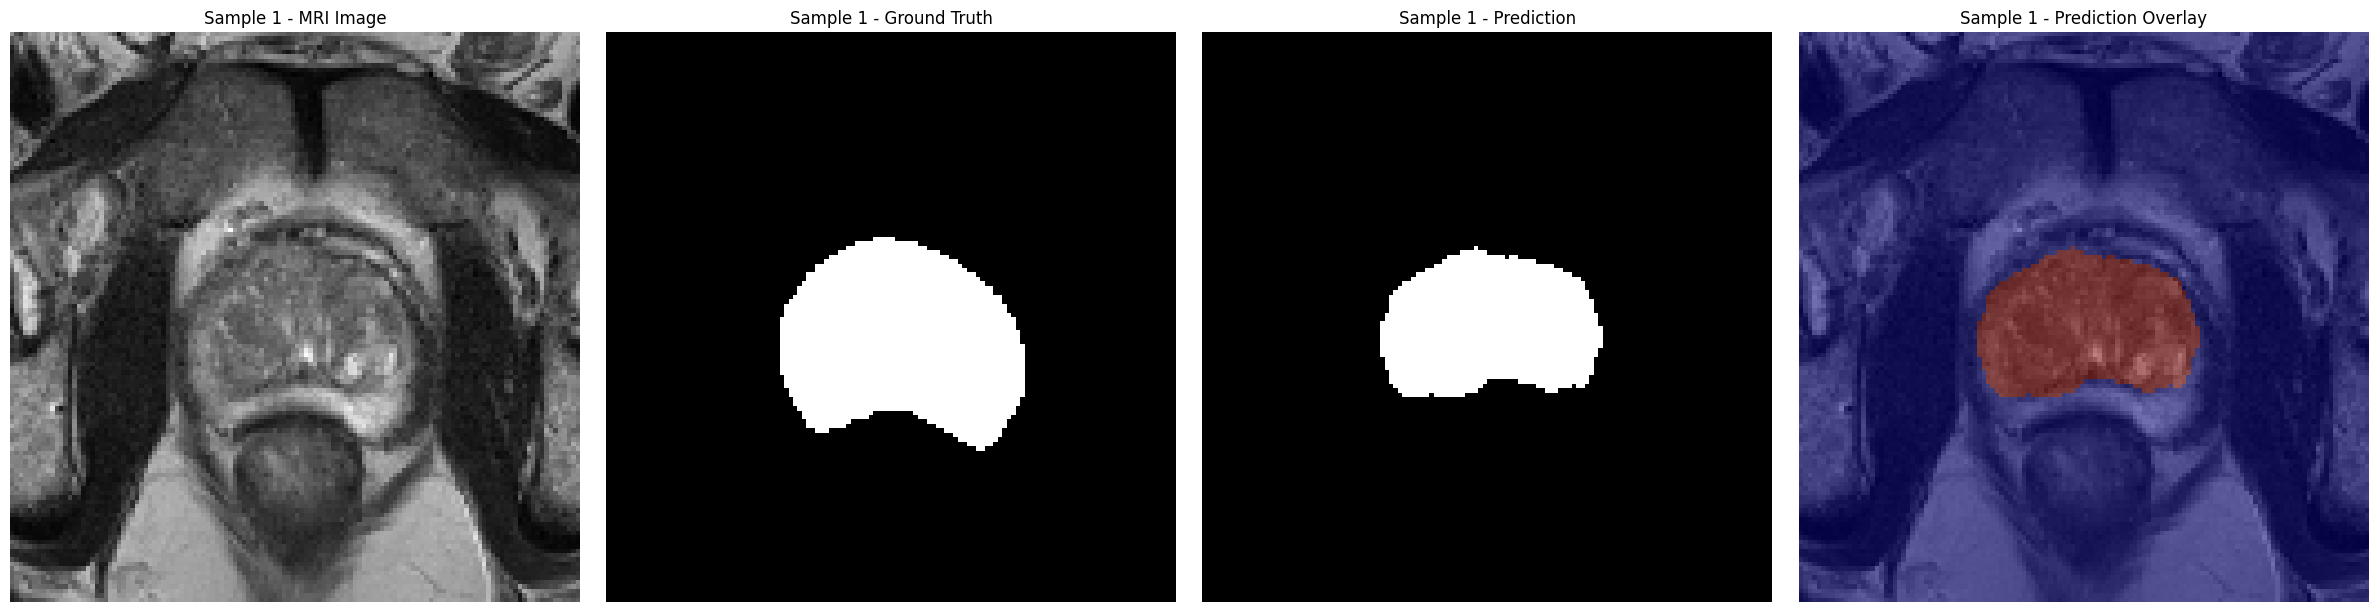

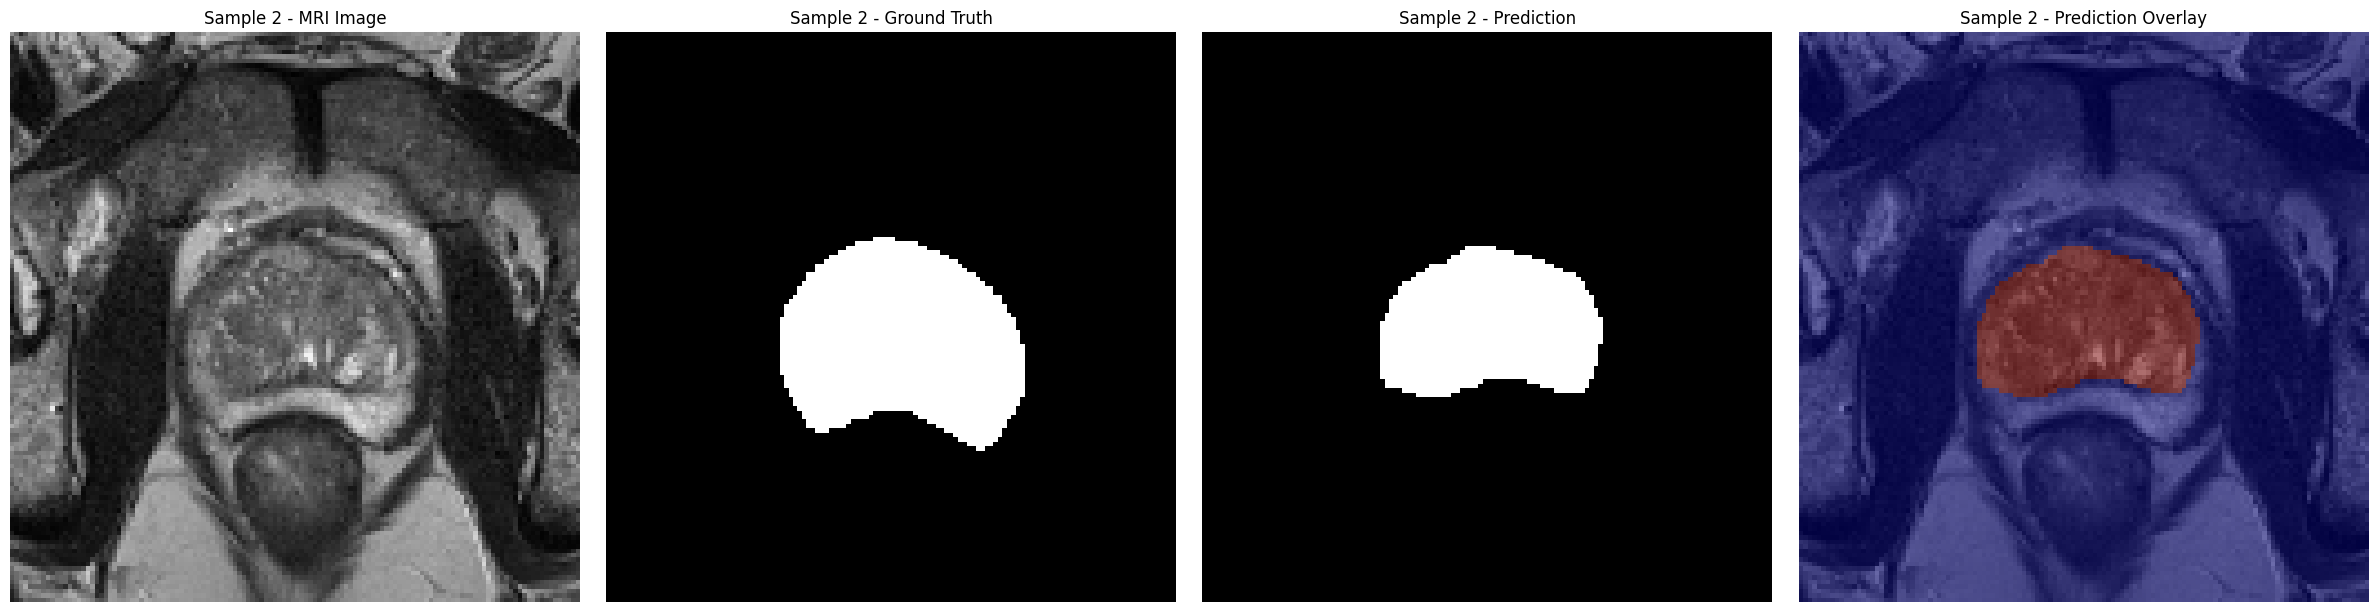


[Ensemble Visualization] Processing batch 2/2...
[Ensemble Visualization] Batch shapes - Images: (2, 128, 128, 1), Masks: (2, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[Ensemble] Collected predictions from 3 models.
[Ensemble] Averaged predictions shape: (2, 128, 128, 1)
[Ensemble Visualization] Predictions thresholded to binary masks.


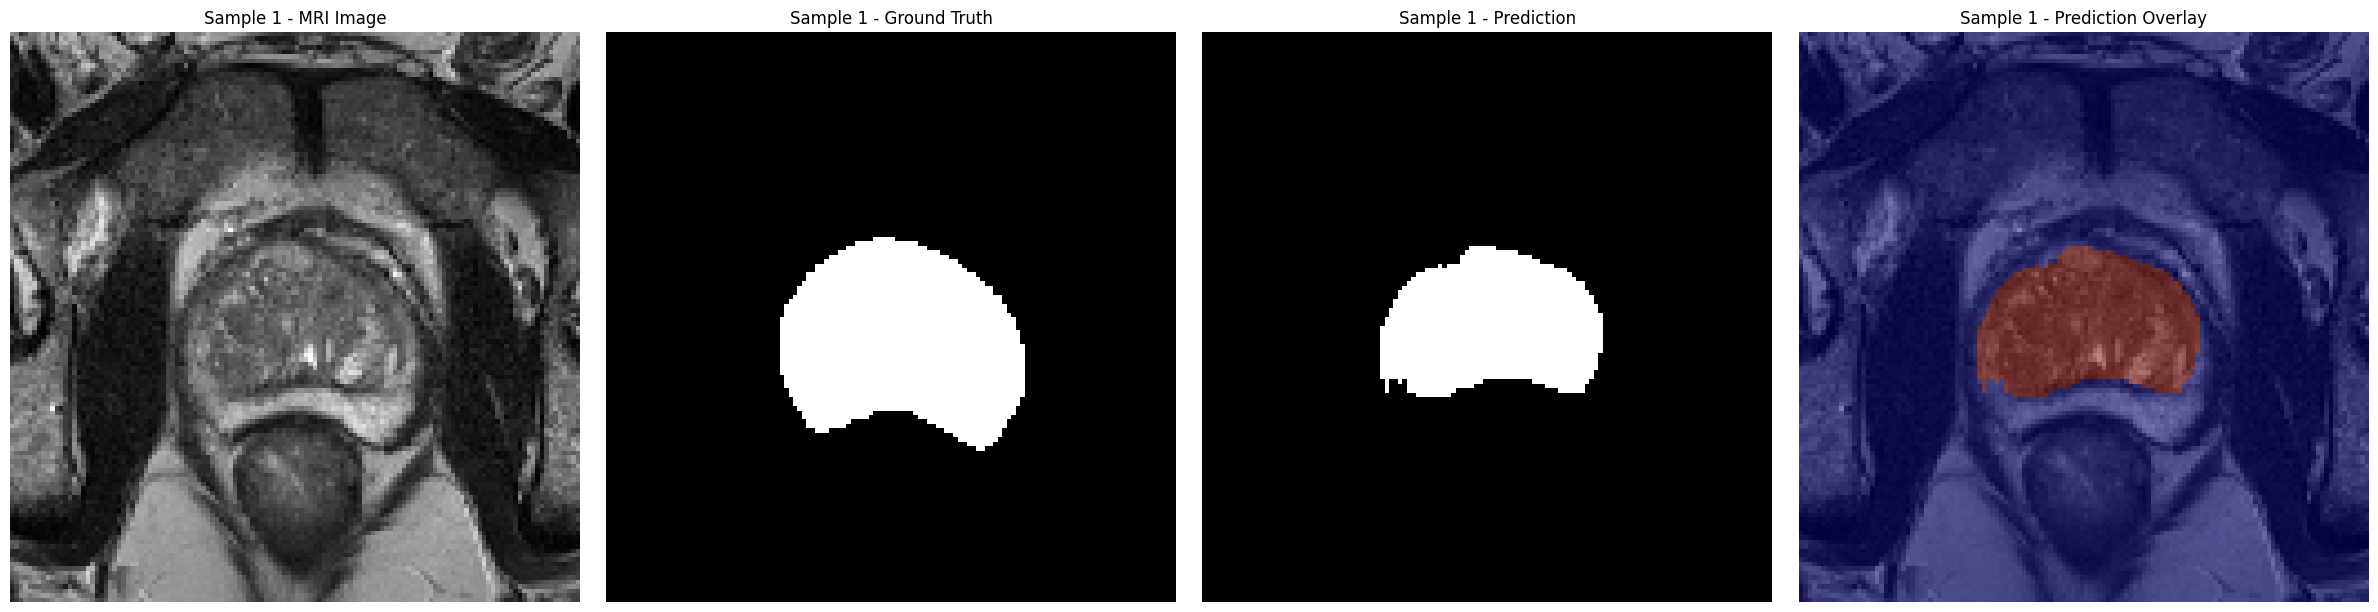

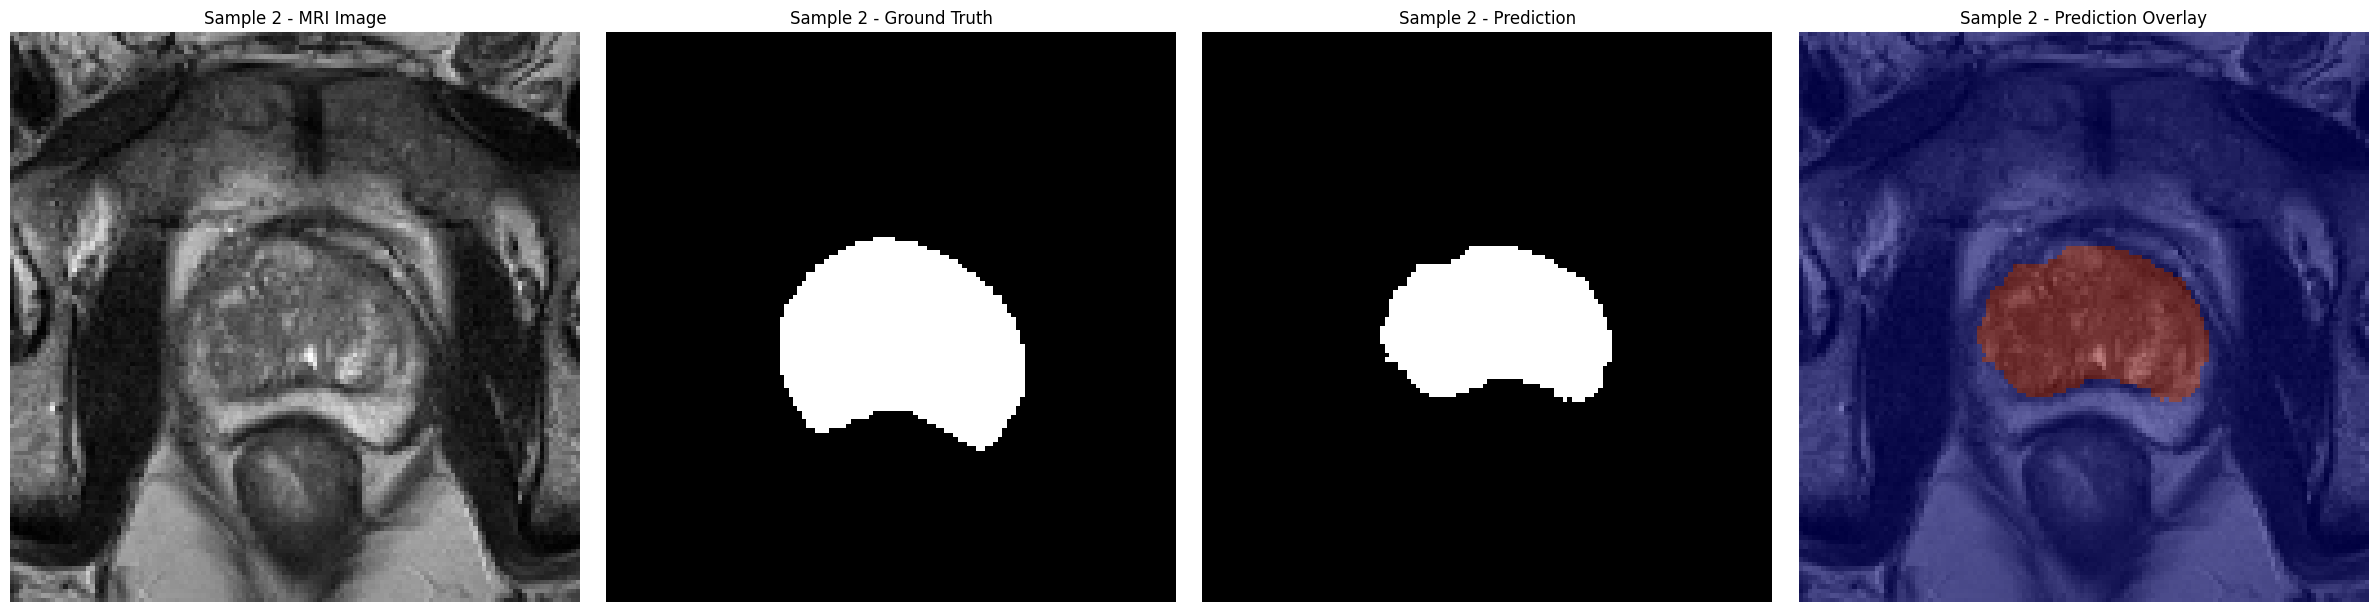

In [23]:
# Assuming you have already loaded the ensemble models as shown earlier

# Define validation steps based on your dataset
validation_steps = 10  # Adjust as needed

val_generator = dataset_generator_2d(
        data_dir=data_dir,
        batch_size=batch_size,
        patch_size=patch_size,
        dataset_type="test",
        augmentations=None
    )

# Evaluate the ensemble
ensemble_metrics = evaluate_ensemble(ensemble_models, val_generator, validation_steps)
print("\n[Final Ensemble Evaluation Metrics]", ensemble_metrics)

# Visualize ensemble predictions
visualize_ensemble_predictions(ensemble_models, val_generator, num_batches=2, num_samples=2)